
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [42]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [43]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler


## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [20 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [44]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [45]:
scaler = MinMaxScaler().fit(X_train.values)
X_train = pd.DataFrame(scaler.transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns, index=X_test.index)

**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [46]:
log_model = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs', max_iter=1000)
log_model.fit(X_train, y_train)

def print_error_rate(X, y, set, model):
    print('The misclassifcation rate for the {} set is: {:.1%}'.format(set, 1 - model.score(X,y)))

print('Unregularized')
print_error_rate(X_train, y_train, 'training', log_model)
print_error_rate(X_test, y_test, 'testing', log_model)


Unregularized
The misclassifcation rate for the training set is: 0.0%
The misclassifcation rate for the testing set is: 23.2%


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  eport the misclassification rate on both the train and test sets.**

In [47]:
lasso_log_model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5)
lasso_log_model.fit(X_train, y_train)

print('Regularized')
print_error_rate(X_train, y_train, 'training', lasso_log_model)
print_error_rate(X_test, y_test, 'testing', lasso_log_model)


Regularized
The misclassifcation rate for the training set is: 9.0%
The misclassifcation rate for the testing set is: 13.9%


**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [48]:
# Define Kfold object and Ks array
kf = KFold(n_splits=5)
ks = [1,2,3,4,5,7,9,10,15,25]

# Save average validation scores from each fold (will take max later)
k_scores = []

# Loop through all Ks
for k in ks:
    # Save validation scores from each fold (will average later)
    validation_scores = []
    for train_idx, test_idx in kf.split(X_train):
        # Train model with k-neighbors on train set
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        # Append score on validation set
        validation_scores.append(model.score(X_train.iloc[test_idx], y_train.iloc[test_idx]))
    # Save the average score from the validation sets (will take max later)
    k_scores.append(np.mean(validation_scores))

# Get the k with highest average score on validation sets
best_k = ks[np.argmax(k_scores)] #7

# Print results with new classifiers using best_k neighbors
print('KNeighborsClassifier(k=7)')
print_error_rate( X_train, y_train, 'train', KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train) )
print_error_rate( X_test, y_test, 'test', KNeighborsClassifier(n_neighbors=best_k).fit(X_test, y_test) )


KNeighborsClassifier(k=7)
The misclassifcation rate for the train set is: 9.8%
The misclassifcation rate for the test set is: 26.5%


**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

kNN false positive rate: 6.6%
kNN false negative rate: 7.3%
LassoCV false positive rate: 6.6%
LassoCV false negative rate: 7.3%
Unregularized false positive rate: 8.6%
Unregularized false negative rate: 14.6%


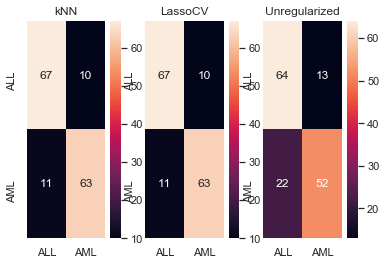

In [49]:
fig, axes = plt.subplots(1,3)
def print_confusion_matrix(model, ax, title):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, pred)
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
    tn, fp, fn, tp = cm.ravel()
    test_len = len(y_test)
    # Assuming positive means AML
    print('{} false positive rate: {:.1%}'.format(title, fp/test_len))
    print('{} false negative rate: {:.1%}'.format(title, fn/test_len))
    ax.set_title(title)
    # Create heatmap
    sns.heatmap(
        cm,
        ax=ax,
        xticklabels=['ALL', 'AML'],
        yticklabels=['ALL', 'AML'],
        annot=True,
        fmt="d",
    )

# Set axes
print_confusion_matrix(
    KNeighborsClassifier(n_neighbors=best_k),
    axes[0],
    'kNN'
)
print_confusion_matrix(
    LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5),
    axes[1],
    'LassoCV'
)
print_confusion_matrix(
    LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs', max_iter=1000),
    axes[2],
    'Unregularized'
)

# Note: SNS labels will display incorrectly when run in Jupyter. For best visualization, run in Terminal.
plt.show()


As we can see with the results below, the unregularized model yields the highest false positive and false negative rates. However, there is virtually no difference between the kNN and the LassoCV models.


<div class='exercise'><b> Question 2 [20 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice with 1-3 sentences.

<hr>

### Solutions

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [50]:
num_components = len(X_train.index)

# scale the datasets 
# TODO check if needed since normalized already
scale_transformer = StandardScaler(copy=True).fit(X_train)
X_train_scaled = scale_transformer.transform(X_train)
X_test_scaled = scale_transformer.transform(X_test)

# reduce dimensions
pca_transformer = PCA(num_components).fit(X_train_scaled)
X_train_decomposed = pca_transformer.transform(X_train_scaled)
X_test_decomposed =  pca_transformer.transform(X_test_scaled)

#print shape
print("Shape of X_train_scaled is: {}".format(X_train_decomposed.shape))
print("Shape of X_test_scaled is: {}".format(X_test_decomposed.shape))


Shape of X_train_scaled is: (601, 601)
Shape of X_test_scaled is: (151, 601)


When trying to create the full PCA decomposition ie. with 7129 predictors, we get a ValueError: "ValueError: n_components=7129 must be between 0 and min(n_samples, n_features)=601 with svd_solver='full'". This means that the number of components cannot exceed the number of observations in X_train. Hence, we used a maximum number of components equal to the number of rows ie. X_train.index.


**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

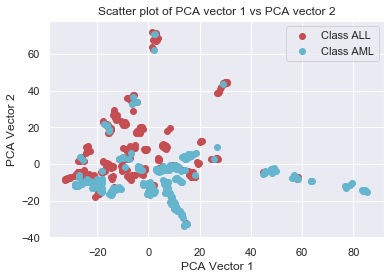

In [51]:
#set up colors and labels
colors = ['r','c']
label_text = ["Class ALL", "Class AML"]

# loop over the ALL and AML classes
for cur_class in [0,1]:
    cur_df = X_train_decomposed[y_train==cur_class]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_class], label=label_text[cur_class])

# plot results
plt.title("Scatter plot of PCA vector 1 vs PCA vector 2")
plt.xlabel("PCA Vector 1")
plt.ylabel("PCA Vector 2")
plt.legend();


Using a scatter plot of the top two PCA vectors is useful because it can be hard for the human eye to visualize and understand a multi-dimensional dataset. With many dimensions, the dataset can start looking like a complex data cloud and it can be hard to make sense of it. Plotting the first two PCA vectors will essentially create a snapshot of the dataset and explain most of the variance, thus helping the observer quickly make sense of the data before diving into more complex analysis. 

**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

Variance explained by each PCA component in X_train (first two vectors): [0.06281546 0.04938133]
Total variance explained by first two vectors: % 11.219678772764455
The number of predictors needed to explain 90.06619693174368 % variance is: 232


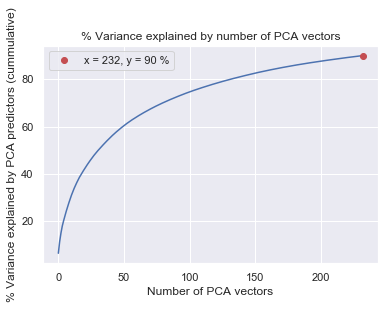

In [63]:
#report variance epxlained in X_train based on top 2 PCA vectors
var_explained = pca_transformer.explained_variance_ratio_[0:2]
print("Variance explained by each PCA component in X_train (first two vectors):", var_explained)
print("Total variance explained by first two vectors: %", np.sum(var_explained * 100))

#report number of PCA vectors needed to explain 90% of variability
var_explained_all = pca_transformer.explained_variance_ratio_

def find_num_pred_90_var():
    num_pred_needed_90 = 0
    tot_variance_explained = 0
    for var in var_explained_all:
        if tot_variance_explained >= 0.9:
            print("The number of predictors needed to explain {} % variance is: {}".format(tot_variance_explained * 100, num_pred_needed_90))
            break
        else:
            tot_variance_explained += var
            num_pred_needed_90 += 1
            
find_num_pred_90_var()

#plot
x = np.linspace(0, 232, num = 232 ) 

total_to_date = 0
cummulative_var_explained = []
for var in var_explained_all[0:232]:
    total_to_date += var *100
    cummulative_var_explained.append(total_to_date)


plt.plot(x, cummulative_var_explained[0:232])
plt.plot(x[231], cummulative_var_explained[231], 'ro', label = "x = 232, y = 90 %")
plt.title("% Variance explained by number of PCA vectors")
plt.xlabel("Number of PCA vectors")
plt.ylabel("% Variance explained by PCA predictors (cummulative)")
plt.legend()
plt.show()


**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and ustify your choice in 1-3 sentences.**

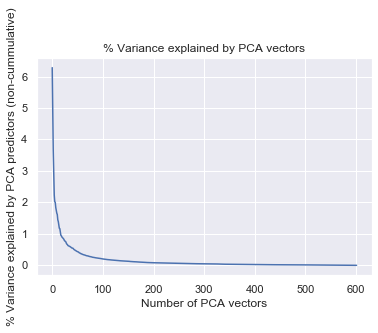

Number of components picked is: 100. It explains 74.76102063663525 % variance


In [71]:
#plot
x = np.linspace(0, 601, num = 601 ) 
    
plt.plot(x, var_explained_all * 100)
plt.title("% Variance explained by PCA vectors")
plt.xlabel("Number of PCA vectors")
plt.ylabel("% Variance explained by PCA predictors (non-cummulative)")
plt.show()

#pick number of PCA components with right balance
print("Number of components picked is: {}. It explains {} % variance".format(100, cummulative_var_explained[100]))


At 100 components, we explain 74.7% of the variance. We believe that it strikes the right balance between representativeness and parsimony. It explains a significant percentage of the variance with a rather small fraction of the total number of possible components.

<div class='exercise'><b> Question 3 [30 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [69]:
# first model: top 2 PCA components
log_model_pca = LogisticRegression(solver = "liblinear")
log_model_pca.fit(X_train_decomposed[:,0:2], y_train)

print('2 PCA components')
print_error_rate(X_train_decomposed[:,0:2], y_train, 'training', log_model_pca)
print_error_rate(X_test_decomposed[:,0:2], y_test, 'testing', log_model_pca)

# second model: top 100 predictors > 74% variance explained
log_model_pca100 = LogisticRegression(solver = "liblinear")
log_model_pca100.fit(X_train_decomposed[:,0:100], y_train)

print('\n100 PCA components')
print_error_rate(X_train_decomposed[:,0:100], y_train, 'training', log_model_pca100)
print_error_rate(X_test_decomposed[:,0:100], y_test, 'testing', log_model_pca100)

# third model: top 232 predictors > 90% variance explained
log_model_pca232 = LogisticRegression(solver = "liblinear")
log_model_pca232.fit(X_train_decomposed[:,0:232], y_train)

print('\n232 PCA components')
print_error_rate(X_train_decomposed[:,0:232], y_train, 'training', log_model_pca232)
print_error_rate(X_test_decomposed[:,0:232], y_test, 'testing', log_model_pca232)

2 PCA components
The misclassifcation rate for the training set is: 24.1%
The misclassifcation rate for the testing set is: 23.2%

100 PCA components
The misclassifcation rate for the training set is: 8.3%
The misclassifcation rate for the testing set is: 15.2%

232 PCA components
The misclassifcation rate for the training set is: 1.7%
The misclassifcation rate for the testing set is: 21.2%


The misclassification rates from question 1 were as follows:

Unregularized
<br />The misclassifcation rate for the training set is: 0.0%
<br />The misclassifcation rate for the testing set is: 23.2%

Regularized
<br />The misclassifcation rate for the training set is: 9.0%
<br />The misclassifcation rate for the testing set is: 13.9%

KNeighborsClassifier(k=7)
<br />The misclassifcation rate for the train set is: 9.8%
<br />The misclassifcation rate for the test set is: 26.5%

As we can see comparing the 6 models, the lowest missclassification rate on the training set was given by the unregularized model. However, that model performed poorly on the testing set. The lowest missclassification rate on the testing set resulted from the regularized model, followed by the PCA model with 100 components. On average, the PCA models didn't outperform the models from question 1 significantly, however the PCA model with 100 components yielded a relatively good misclassification rate on the testing set. Perhaps, with an adjusted number of components, we could get the misclassification rate to go down even further.






**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

2 PCA components
The misclassifcation rate for the training set is: 21.6%
The misclassifcation rate for the testing set is: 21.2%

100 PCA components
The misclassifcation rate for the training set is: 9.8%
The misclassifcation rate for the testing set is: 13.2%

232 PCA components
The misclassifcation rate for the training set is: 9.7%
The misclassifcation rate for the testing set is: 13.2%

50 PCA components
The misclassifcation rate for the training set is: 9.8%
The misclassifcation rate for the testing set is: 13.2%

The best performing model according to cross validation is the 232 component PCA model as it has a slightly lower misclassification score on the training set. However, 100 component and 50 component PCA models have very similar misclassification rates so it is close to a tie.


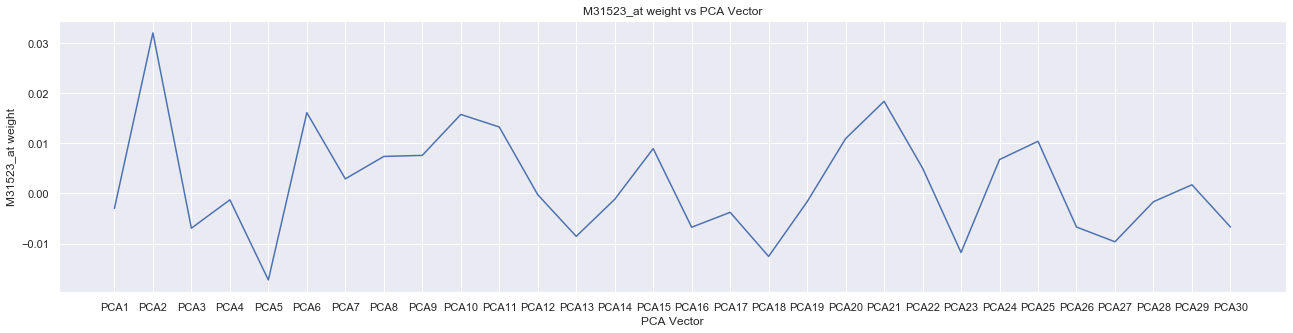

As can be seen on the plot, the weight of M31523_at by PCA vector varies a lot and even for the PCA vector with the highest weight (PCA 2), the weight of M31523_at doesn't exceed 0.04. Hence, it has a limited impact.


In [102]:
# first model: top 2 PCA components
CV_log_model = LogisticRegressionCV(solver='liblinear', cv=3,  max_iter=1000)
CV_log_model.fit(X_train_decomposed[:,0:2], y_train)

print('2 PCA components')
print_error_rate(X_train_decomposed[:,0:2], y_train, 'training', CV_log_model)
print_error_rate(X_test_decomposed[:,0:2], y_test, 'testing', CV_log_model)

# second model: top 100 predictors >74% variance explained
CV_log_model100 = LogisticRegressionCV(solver='liblinear', cv=3,  max_iter=1000)
CV_log_model100.fit(X_train_decomposed[:,0:100], y_train)

print('\n100 PCA components')
print_error_rate(X_train_decomposed[:,0:100], y_train, 'training', CV_log_model100)
print_error_rate(X_test_decomposed[:,0:100], y_test, 'testing', CV_log_model100)

# third model: top 232 predictors > 90% variance explained
CV_log_model232 = LogisticRegressionCV(solver='liblinear', cv=3,  max_iter=1000)
CV_log_model232.fit(X_train_decomposed[:,0:232], y_train)

print('\n232 PCA components')
print_error_rate(X_train_decomposed[:,0:232], y_train, 'training', CV_log_model232)
print_error_rate(X_test_decomposed[:,0:232], y_test, 'testing', CV_log_model232)

#optional model: top 50 predictors
CV_log_model50 = LogisticRegressionCV(solver='liblinear', cv=3,  max_iter=1000)
CV_log_model50.fit(X_train_decomposed[:,0:50], y_train)

print('\n50 PCA components')
print_error_rate(X_train_decomposed[:,0:50], y_train, 'training', CV_log_model50)
print_error_rate(X_test_decomposed[:,0:50], y_test, 'testing', CV_log_model50)

#best model
print("\nThe best performing model according to cross validation is the 232 component PCA model as it has a slightly lower misclassification score on the training set. However, 100 component and 50 component PCA models have very similar misclassification rates so it is close to a tie.")

#relationship between M31523_at and Cancer_type
coefficients = pd.DataFrame(pca_transformer.components_[0:30], columns = X_train.columns)
plt.figure(figsize = (22,5))
plt.plot(['PCA%d' % (i+1) for i in range(30)], coefficients['M31523_at'])
plt.xlabel('PCA Vector')
plt.ylabel('M31523_at weight')
plt.title('M31523_at weight vs PCA Vector')
plt.show()
print("As can be seen on the plot, the weight of M31523_at by PCA vector varies a lot and even for the PCA vector with the highest weight (PCA 2), the weight of M31523_at doesn't exceed 0.04. Hence, it has a limited impact.")


**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

The area-under-the-ROC-curve explains how well the model seperates data into different classes ie. it answers the questions "How good is the model at classifying the data?" and "How certain can we be about the classification decision?". The misclassification rate on the other hand only tells us what % of data points have not been classified into the right group. It doesn't tell us anything about the certainty with which a model classifies the data.

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

Accuracy score for unregularized model: 76.69357669357669 %
Accuracy score for kNN model: 86.07406107406106 %
Accuracy score for LassoCV model: 86.07406107406106 %
Accuracy score for 2 PCA model: 76.85152685152686 %
Accuracy score for 100 PCA model: 84.72270972270972 %
Accuracy score for 50 PCA model: 86.07406107406106 %
Accuracy score for 232 PCA model: 78.74692874692875 %
There is a tie between kNN, LassoCV and 50 component PCA for best model. We will pick the LassoCV model for its simplicity and efficiency.


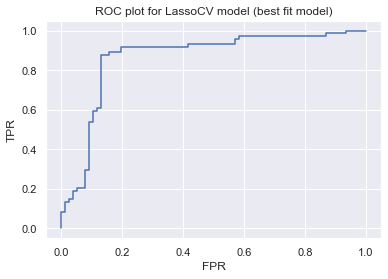

As we can see from the plot, the cutoff for classification is at around 0.2 FPR. After that, the curve reaches a plateau and there is little gain.


In [93]:
# Unregularized
y_unreg = log_model.predict(X_test)
score_unreg = metrics.roc_auc_score(y_test, y_unreg)
print("Accuracy score for unregularized model: {} %".format(score_unreg*100))

# kNN
knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)
y_knn = knn_model.predict(X_test)
score_knn = metrics.roc_auc_score(y_test, y_knn)
print("Accuracy score for kNN model: {} %".format(score_knn*100))

# LassoCV
y_lasso = lasso_log_model.predict(X_test)
score_lasso = metrics.roc_auc_score(y_test, y_lasso)
print("Accuracy score for LassoCV model: {} %".format(score_lasso*100))

# 2 PCA
y_2cv = log_model_pca.predict(X_test_decomposed[:,0:2])
score_2cv = metrics.roc_auc_score(y_test, y_2cv)
print("Accuracy score for 2 PCA model: {} %".format(score_2cv*100))

# 100 PCA
y_100cv = log_model_pca100.predict(X_test_decomposed[:,0:100])
score_100cv = metrics.roc_auc_score(y_test, y_100cv)
print("Accuracy score for 100 PCA model: {} %".format(score_100cv*100))

# 50 PCA
log_model_pca50 = LogisticRegression(solver = "liblinear")
log_model_pca50.fit(X_train_decomposed[:,0:50], y_train)
y_50cv = log_model_pca50.predict(X_test_decomposed[:,0:50])
score_50cv = metrics.roc_auc_score(y_test, y_50cv)
print("Accuracy score for 50 PCA model: {} %".format(score_50cv*100))

# 232 PCA
y_232cv = log_model_pca232.predict(X_test_decomposed[:,0:232])
score_232cv = metrics.roc_auc_score(y_test, y_232cv)
print("Accuracy score for 232 PCA model: {} %".format(score_232cv*100))

#pick best
print("There is a tie between kNN, LassoCV and 50 component PCA for best model. We will pick the LassoCV model for its simplicity and efficiency.")

#plot ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, lasso_log_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC plot for LassoCV model (best fit model)')
plt.show()
print("As we can see from the plot, the cutoff for classification is at around 0.2 FPR. After that, the curve reaches a plateau and there is little gain.")

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

Based on AUC, there is not a clear winner. As we saw, the accuracy score for kNN, LassoCV and PCA were the same or very similar. Since cancer outcomes are so crucial, I might use all three top performing models and triangulate the predictions.


<div class='exercise'><b> Question 4: COMPAS [30 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.**

In [ ]:
compas_df = pd.read_csv('data/compas.csv')

# your code here



**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

In [ ]:
# your code here


**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

*your answer here*

**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

In [ ]:
# your code here


**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [ ]:
# your code here


**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

*your answer here*


---